Forked from Basic Feature Benchmark, courtesy inversion (https://www.kaggle.com/inversion/basic-feature-benchmark)

# Executive Summary
This Kernel demonstrates a "zero feature extraction" method to solve the problem. Keeps trainable parameter count very low.

This Kernel demonstrates a "Leave Two Out" k-means cross-validation scheme to insure accurate results.

# A "zero feature extraction" method to solve the problem.

I am against complicated feature extraction algorithms prior to machine learning. It seems to defeat the purpose of having artificial intelligence. Also, if you are able to extract features well enough, you can just use a nearest neighbor (kNN) algorithm so a good sorting algorithm is more useful than an iterative error minimization algorithm.

There is no need to extract features. Most feature extraction uses Fourier Transforms, or the FFT version of the same to extract frequency components from a signal. When the signals are not continuous, then a windowing algorithm and/or a wavelet convolution algorithm is used. The problem with the latter is the selection of the optimal wavelet filter.

In this Kernel, I show you how to not only use Convolutional Neural Networks (CNN) to create a Discrete Wavelet Transform (DWT) and Perceptron’s (Dense) layers to extract statistical and trend information from the DWT; but I also demonstrate that the algorithm optimizes to the best wavelet filters at each layer of the transformation.

As you may recall, DWT convolves the signal with a low pass filter g[0], called a wavelet. The results of this convolution are called the approximation coefficients. Simultaneously, the original signal is convolved with a quadrature mirror of the original filter h[0], which extracts all the remaining high frequency components. The results of this convolution are called the detail coefficients. 

Since the original signal minus the approximation coefficients should equal the detail coefficients, I sometimes refer to the latter as “the residual.”

During Keras based on Tensorflow CNN training, done in batches, I have not found a convenient way to get copies of the trained wavelet filters in the middle of training. For this reason, I propose the use of a pseudo-residual in place of the original residual. The pseudo-residual is calculated as follows:

Step 1, calculate the approximation coefficients (these are precisely the outputs of a “Conv” Keras layer)

Step 2, since we do not have the original wavelet data (called the “kernels” in Keras documentation) we have to make some inferences. We infer that if the output of the convolution is very large, then it must have been a good match with the wavelet. Similarly, If it is a large negative number, it must be a good match, but flipped 180 degrees in phase (upside-down). Only if the values are relatively small, is there a poor match with the wavelet shape. So in step 2, we use an activation function on the “Conv” output (approximation coefficients) that first takes the hyperbolic tangent (‘tanh’ in Keras), and then the absolute value.

Step 3, we multiply the activated approximation coefficients by the original signal. 

Step 4, finally we subtract step 3 from the original signal, leaving mostly what was poorly approximated, the residual, and hence the detail coefficients.

See the code below for details.

NOTE: some variations from traditional DWT’s used in literature…

1 – Normally after each transformation, the signals are down sampled by two (2). Here we allow down sampling by any integer value (AveragePooling in Keras terminology)

2 – Normally, we calculate statistical details at each layer of transformation. Here we take an additional step, and down sample to a constant shape (MaxPooling) to remove phase information (so if a particular signal element is shifted by a couple of pixels or samples, the result is the same)

3 – Normally statistical details are calculated using traditional statistical analysis (mean, mode, median, standard deviation, it’s square the variance, etc). Here we use a single layer perceptron (Dense in Keras terminology) to sort out any such patterns.



# A "Leave Two Out" k-means cross-validation scheme to insure accurate results."}]

When using a k-means cross validation scheme, we take a portion of the training set and save it for validation. The number of times this is repeated is “k”. When using a traditional “Leave One Out” (LOO) k-means cross-validation, we are taking the most rigorous approach. We leave one of the experiments (one of the people in a an experiment involving humans, or one earthquake experiment here). This is the most rigorous because we are not seeding the training set with “parts of that experiment” – since in the real world, we won’t get that luxury.
The modification I made in this Kernel is to pair up experiments (so “Leave Two Out”) yielding a k value of 8. So it is an 8-fold cross validation with LTO experiments.
Each of these creates a solution neural network, and together they form an ensemble of 8 solutions, whose results are averaged as an ensemble.
Note: Each solution is deleted before calculating the next, to save memory in Kaggle.


In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
print(os.listdir("../input"))

['test', 'train.csv', 'sample_submission.csv']


In [2]:
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.svm import NuSVR
from sklearn.metrics import mean_absolute_error

# For future use - to use CNN to extract features instead pf simple min/max/etc..
from keras.layers import * 
from keras.models import Model, Sequential, load_model
from keras import backend as K 
from keras import optimizers 
from keras.callbacks import * 
from keras.backend import clear_session

Using TensorFlow backend.


In [3]:
rows = 150_000
segment = 0
for chunk in tqdm(pd.read_csv('../input/train.csv', dtype={'acoustic_data': np.int16, 'time_to_failure': np.float16}, chunksize=rows * 100)) :
    if (segment == 0) :
        X_train = np.int16(chunk.acoustic_data.values)
        y_raw = np.float16(chunk.time_to_failure.values)
    else: 
        X_train = np.concatenate((X_train, np.int16(chunk.acoustic_data.values)))
        y_raw = np.concatenate((y_raw, np.float16(chunk.time_to_failure.values)))
    segment += 1


42it [02:57,  5.03s/it]


In [4]:
# find start and endpoints of the sixteen (16) Earthquake Trials
# Including the "cleanup" of segments that traverse experiment boundaries
start = np.zeros(17, dtype=np.int32)
end = np.zeros(17, dtype=np.int32)
index = 0
for i in tqdm(range (0,y_raw.shape[0] - rows, rows)) :
    if i == 0:
        start[index] = i;
        end[index] = i;
    if y_raw[i+rows] > y_raw[i] :
        end[index] = i
        index += 1
        start[index] = i
        end[index] = i + rows
        # "Clean Up" the segment that traverses the experment boundary
        # This will be the beginning segment of a new experiment.
        boundary = 0
        for j in range(rows - 1) :
            if y_raw[i + j + 1] > y_raw[i + j] :
                boundary = j
        # "Clean up" for now means zero out seismic data.
        X_train[i:i+boundary] = 0
# Now let's see how big each experiment is, in terms of the maximum number of 150000 sample rows 
running_count = 0
for i in range (16) :
    count = np.int32((end[i] - start[i])/rows)
    print ("Experiment", i, "has", count, "segments of 150000 samples each")
    running_count += count
    start[i] = np.int32((start[i])/rows)
    end[i] = np.int32((end[i])/rows)

segments = np.int32(end[15])


100%|██████████| 4194/4194 [00:01<00:00, 3432.78it/s]

Experiment 0 has 37 segments of 150000 samples each
Experiment 1 has 296 segments of 150000 samples each
Experiment 2 has 364 segments of 150000 samples each
Experiment 3 has 228 segments of 150000 samples each
Experiment 4 has 325 segments of 150000 samples each
Experiment 5 has 207 segments of 150000 samples each
Experiment 6 has 181 segments of 150000 samples each
Experiment 7 has 414 segments of 150000 samples each
Experiment 8 has 203 segments of 150000 samples each
Experiment 9 has 247 segments of 150000 samples each
Experiment 10 has 293 segments of 150000 samples each
Experiment 11 has 283 segments of 150000 samples each
Experiment 12 has 227 segments of 150000 samples each
Experiment 13 has 220 segments of 150000 samples each
Experiment 14 has 378 segments of 150000 samples each
Experiment 15 has 243 segments of 150000 samples each


In [5]:
X_train.shape

(629145480,)

In [6]:
X_train = np.reshape(X_train[0:(segments * rows)], (segments, rows,1))
print(X_train.shape)
print("Sanity check, shape, segments, and running count", segments, X_train.shape[0], running_count)


(4146, 150000, 1)
Sanity check, shape, segments, and running count 4146 4146 4146


Example of cleaned up segment starting a new experiment


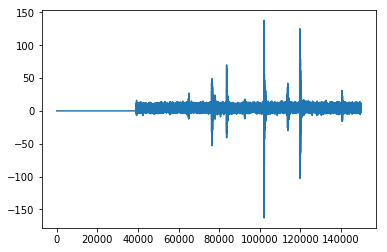

In [7]:
print("Example of cleaned up segment starting a new experiment")
plt.plot(X_train[start[8]])


In [8]:
y_train = np.zeros(segments)
for segment in tqdm(range(segments)):
    seg = y_raw[segment*rows:segment*rows+rows]
    y_train[segment] = seg[-1]
median = np.median(y_train)
overall_max = y_train.max()
print ("time to failure median", median, "and maximum", overall_max)

100%|██████████| 4146/4146 [00:00<00:00, 403695.43it/s]

time to failure median 5.291015625 and maximum 16.109375


The original arget data


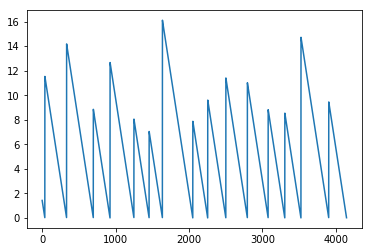

In [9]:
print("The original arget data")
plt.plot(y_train)

In [10]:
# Clean up unused RAM 
del y_raw
del chunk

In [11]:
submission = pd.read_csv('../input/sample_submission.csv', index_col='seg_id')

In [ ]:
rows = 150_000
segment = 0
for seg_id in tqdm(submission.index):
    seg = pd.read_csv('../input/test/' + seg_id + '.csv')
    if (segment == 0) :
        X_test = np.int16(seg.acoustic_data.values)
    else: 
        X_test = np.concatenate((X_test, np.int16(seg.acoustic_data.values)))
    segment += 1
test_segments = segment

 38%|███▊      | 985/2624 [02:23<07:46,  3.51it/s]

In [ ]:
# plot the head of the seismic acoustic data
plt.plot(X_test[0:150000])

In [ ]:
X_test = np.reshape(X_test, (test_segments, rows,1))
X_test.shape

In [ ]:
# Sanity check - plot the head of the seismic acoustic data
plt.plot(X_test[0,:])

Back to CNN creation

Discrete Wavelet Transform (courtesy Wikipedia.org)
![Discrete Wavelet Transform (courtesy Wikipedia.org)](https://upload.wikimedia.org/wikipedia/commons/2/22/Wavelets_-_Filter_Bank.png)

Where g(n) is the low pass filter, yielding the approximation coefficients, and
h(n) is the corresponding high pass filter (quadrature mirror of g(n)) yielding the detail coefficients

In [ ]:
# DWT (diagram above) using pseudo-residual
        # PSEUDO-RESIDUAL
        # the above variable "conv" represents an approximation of the original (scaled) signal created by convolving
        # one of the "scale" number of filters of size "wavelet_size" with the original signal and coming up with 
        # convolution values "conv" at each point (strides = 1) along that signal.
        # we coud use these convolved values, along with the wavelet (filter) to recreate an approximation of the
        # original signal - if only KERAS ON TESORFLOW would give us a function to see those filter values.
        # I cannot see such a function. 
        #
        # Nevertheless, we do know that the greater the value of "conv" at a particular point, the closer the match of the
        # original signal was to the wavelet filter shape, centered at that point. The smaller the value, the worse
        # the match. 
        #
        # In traditional wavelet decomposition, at each iteration, the residual is calculated.
        # The residual is the difference between the original signal and the aforementioned approximation. We can't
        # calculate the approximation (as discussed above) but we do know it should be closest to the original signal
        # when "conv" is greatest, and farthest away from the original signal when "conv" is lowest.
        #
        # I therefore propose to create a "pseudo-residual" which approximates some aspects of an actual residual.
        # by -1 to +1 limiting the values of "conv" ('tanh' activation), taking the absolute value, 
        # and then multiplying that by the original signal, we can create this 
        # pseudoresidual - a function who most closely equals the original signal
        # in places where the wavelet fileter FAILS to closely match, and most closely equals zero in places where the wavelet
        # filter SUCCEEDS in closely matching the original signal.
        
import math
from math import floor, log

# Make a CNN Model to learn features
def make_model(rows = 150000, linear = True) :
    # rows is the size of each row of sequential data
    # linear is whether or not the target is a linear value or not (e.g. binary w/output activation is sigmoid)
    
    scale = 12              # the size of the CNN or similarly, the number of wavelet shapes to try and learn
    dropout = 0.1           # the percentage of training examples to randomly skip each epoch 
    pool_base = 10          # The number of values to average when pooling (DWT uses 2, but here we can modify this)
    wavelet_size = 50       # The size of the individual convolution or similarly, the number of data points in the wavelet filter

    input_layer = Input((rows,1))

    
    # This is how far repeated pooling (scaling down) can go before we're down to < wavelet_size sample
    # padding = "valid" for no padding instead of padding = "same" for padding with 0's
    pad = "same"
    depth_low = int(math.floor(math.log(wavelet_size)/math.log(pool_base))) 
    depth = int(math.floor(math.log(rows)/math.log(pool_base))) - depth_low
    
    print ("Depth :", depth,"\n")

    ########
    #  A   #
    ########
    # MAY NEED TO LOOK INTO ACTIVATION FUNCTION FURTHER. 
    # SHOULD WE SWITCH TO A VAN HALEN SHAPED ACTIVATION FOR 180 PHASE INCLUSION?
    # v36 added this as the absolute value of the tanh activation function
    seq_conv = []
    seq_conv_pool = []

    seq_residual = []
    seq_residual_pool = []
    
    # create the first level
    seq_conv_pool.append(BatchNormalization()(input_layer))
    seq_conv_pool[0] = Dropout(dropout)(seq_conv_pool[0])

    for i in range(depth) :

        # find the output of filter g(i) and therefore the detail coefficients
        seq_conv.append(Conv1D(scale, wavelet_size, strides = 1, padding=pad)(seq_conv_pool[i]))

        # create the pseudo-residual which is an approximation of the output of filter h(i), and therefore the detail coefficients
        # apply activation function 
        seq_residual.append(Activation('tanh')(seq_conv[i]))
        seq_residual[i] = Lambda(lambda x: abs(x))(seq_residual[i])
        # remove the approximation from the original signal, leaving the detail coefficients (residual)
        seq_residual[i] = Multiply()([seq_residual[i], seq_conv_pool[i]])
        seq_residual[i] = Subtract()([seq_conv_pool[i], seq_residual[i]])

        # apply the standard "relu" activation function for use in NN training (doesn't seem to converge well unless we do this)
        seq_conv[i] = Activation('relu')(seq_conv[i])
        
        # apply downscaling to g(i) to be used to calculate the next g(i)
        seq_conv_pool.append((AveragePooling1D(pool_size = pool_base)(seq_conv[i])))

        # finish up by pooling all layers down to the same size
        # this removes remaining phase information and chunks the entire time sequence into approx "wavelet_size" number of chunks based on depth calculations
        seq_residual_pool.append(MaxPooling1D(pool_size = pool_base ** (depth - i))(seq_residual[i]))
        seq_conv_pool[i] = MaxPooling1D(pool_size = pool_base ** (depth - i))(seq_conv[i])


    # one last one without the pooling afterwards
    seq_conv.append(Conv1D(scale, wavelet_size, strides = 1, padding=pad)(seq_conv_pool[depth]))
    seq_conv[depth] = ReLU(max_value = 1)(seq_conv[depth])
    

    ########
    #  B   #
    ########
    # Give each of the above convolutions of convolutions their own dense layer
    # first by flattening the convolutional layer and then by adding a simple relu activated set of perceptrons
    fscp = []
    dscp = []
    for i in range(depth) :
        # for each layer of depth i, concatenate the g(i) output and the h(i) output and flatten
        fscp.append(concatenate([seq_conv_pool[i], seq_residual_pool[i]]))
        fscp[i] = Flatten()(fscp[i])
        # then create a single perceptron (dense layer) to represent that layer
        dscp.append(Dense(1, activation='relu')(fscp[i]))
    # One last one without the pooling afterwards
    fscp.append(Flatten()(seq_conv[depth]))
    dscp.append(Dense(1, activation='relu')(fscp[depth]))

    # concatenate all of these dense layers into one.
    con_cat_d2 = dscp[0]
    for i in range(depth) :
        con_cat_d2 = concatenate([con_cat_d2,dscp[i+1]])
        

    
    ########
    #  C   #
    ########
    # Penultimate layer before output simply provides an ability to resolve simple but nolinear separation 
#    dense7 = Dense(scale, activation='relu')(con_cat_d2)   
    dense7 = con_cat_d2
    
    # output layer
    if (linear == True) : 
        dense8 = Dense(1, activation='linear')(dense7)
#        dense8 = Dense(1, activation='relu')(dense7)
    else :
        dense8 = Dense(1, activation='sigmoid')(dense7)

    output_layer = dense8
    
    model2 = Model(input_layer, output_layer)

    if (linear == True) : 
        model2.compile(loss='mse', optimizer='adam')
    else :
        # by all rights, should probably use binary_crossentropy below, but seems to get stuck if I do (mse works). Will investigate further at some other time.
        model2.compile(loss='binary_crossentropy', optimizer='adam')
    return model2

In [ ]:
print(X_train.shape[0], X_test.shape[0])

In [ ]:
# we will be slowing down the learning using "Dropouts" (see above) so the patience needed to exit local minima can be large
patience = 10 # Overrunning CPU time of 9 hours... so lowereed patience from 15
# Probably will never reach this many epochs, but want to use a number larger than what we expect
epochs = 300

y_pred_train = np.zeros(X_train.shape[0])
y_pred_test = np.zeros(X_test.shape[0])

# Use LTO from the 16 earthquake experiments, so eight pairs of experiments to leave out
for fold in range (0,16,2) :
    
    if fold >= 14 :
        X_t = X_train[start[0]:end[13]]
        X_v = X_train[start[14]:end[15]]
        y_t = y_train[start[0]:end[13]]
        y_v = y_train[start[14]:end[15]]
    elif fold == 0 :
        X_t = X_train[start[2]:end[15]]
        X_v = X_train[start[0]:end[1]]
        y_t = y_train[start[2]:end[15]]
        y_v = y_train[start[0]:end[1]]
    else :
        X_t = np.concatenate((X_train[start[0]:end[fold - 1]], X_train[start[fold + 2]:end[15]]))
        X_v = X_train[start[fold]:end[fold + 1]]
        y_t = np.concatenate((y_train[start[0]:end[fold - 1]], y_train[start[fold + 2]:end[15]]))
        y_v = y_train[start[fold]:end[fold + 1]]
    
    print('Fold', fold)
    K.clear_session()
    
    model = make_model()

    checkpointer = ModelCheckpoint('LANL_value', verbose=1, save_best_only=True)

    earlystopper = EarlyStopping(patience = patience, verbose=1) 

    results = model.fit(X_t, y_t, 
                    epochs = epochs, batch_size = 32,
                    callbacks=[earlystopper, checkpointer], 
                    validation_data = [X_v, y_v])

    model = load_model('LANL_value')
    
    y_pred_train += model.predict(X_train)[:,0] / 8
    y_pred_test += model.predict(X_test)[:,0] / 8

In [ ]:
print(model.summary())

In [ ]:
# y_pred_train *= 8
# fold

In [ ]:
# SCORE FOR SCALED TRAINING SET
plt.figure(figsize=(6, 6))
plt.scatter(y_train, y_pred_train)
plt.xlim(0, 20)
plt.ylim(0, 20)
plt.xlabel('actual', fontsize=12)
plt.ylabel('predicted', fontsize=12)
plt.plot([(0, 0), (20, 20)], [(0, 0), (20, 20)])
plt.show()

In [ ]:
score = mean_absolute_error(y_train, y_pred_train)
print(f'Score: {score:0.3f}')
best_mult = 1
best_offset = 0
best_score = score
for imult in tqdm(range (1, 500, 1)) :
    mult = imult / 100
    for ioffset in range (-50, 50, 1) :
        offset = ioffset / 10
        score = mean_absolute_error(y_train, ((y_pred_train + offset) * mult))
        if score < best_score :
            best_score = score
            best_offset = offset
            best_mult = mult

In [ ]:
print("Best multiplier and offset are", best_mult, best_offset)
print("Best score", best_score)

# Use the same multiplier and offset as discovered above.
y_pred_train += best_offset
y_pred_train *= best_mult

# get rid of invalid answers (< 0)
for i in range(segments) :
    if y_pred_train[i] < 0 :
        y_pred_train[i] = 0
        
# SCORE FOR SCALED TRAINING SET
plt.figure(figsize=(6, 6))
plt.scatter(y_train, y_pred_train)
plt.xlim(0, 20)
plt.ylim(0, 20)
plt.xlabel('actual', fontsize=12)
plt.ylabel('predicted', fontsize=12)
plt.plot([(0, 0), (20, 20)], [(0, 0), (20, 20)])
plt.show()


In [ ]:
# print("saving Un-Scaled TIME_TO_FAILURE estimates")
# y_pred = y_pred_test
# submission['time_to_failure'] = y_pred
# submission.to_csv('unscaled_submission.csv')
# 
# print("done!")

In [ ]:
# Use the same multiplier and offset as discovered above.
y_pred_test += best_offset
y_pred_test *= best_mult
# get rid of invalid answers (< 0)
for i in range(test_segments) :
    if y_pred_test[i] < 0 :
        y_pred_test[i] = 0

In [ ]:
print("saving TIME_TO_FAILURE estimates")
y_pred = y_pred_test
submission['time_to_failure'] = y_pred
submission.to_csv('submission.csv')

print("done!")

In [ ]:
plt.plot(y_pred_test)